In [3]:
import librosa
import pickle
import numpy as np

# Load their tuned model from file
with open("model/their_tuned_model.pkl", 'rb') as file:
    pickle_model = pickle.load(file)

# Load the standard scaler that was used to train their model
from joblib import load
scaler = load('model/std_scaler.bin')

instr_list = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

def score_prob_of_being(y, sr=44100, being=None, sim=False):
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)}'

    df = np.array([[float(x) for x in to_append.split(" ")]])
    
    X = scaler.transform(df)
    
    if being:
        mse = np.sqrt(np.mean(np.power(y - orig_y, 2))) if sim else 0
        return pickle_model.predict_proba(X)[0][instr_list.index(being)] - mse
    else:
        return pickle_model.predict_proba(X)[0]

In [69]:
songname = "dataset/IRMAS-TrainingData/voi/[voi][pop_roc]2353__3.wav"
orig_y, sr = librosa.load(songname, sr=44100)
orig_y = np.real(librosa.istft(np.real(librosa.stft(orig_y))))
print("Probability of being what it actually is:", score_prob_of_being(orig_y, sr, "voi"))
tricked_class = "voi"
print("Probability of being what we want it to be:", score_prob_of_being(orig_y, sr, tricked_class))

Probability of being what it actually is: 0.27558016796473095
Probability of being what we want it to be: 0.27558016796473095


In [72]:
import numpy as np
from deap import base, creator, tools, algorithms

# Define the problem: Maximizing the fitness of the spectrogram
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# Define the functions for initialization, mutation, crossover, and evaluation
def init_individual():
    y, sr = librosa.load(songname, sr=44100)
    return np.real(librosa.stft(y))

def mutate(individual, indpb):
    # Mutate an individual by adding a small random value to each element
    individual += np.random.normal(0, indpb, individual.shape)
    return individual,

def crossover(parent1, parent2):
    # Perform crossover by taking the average of corresponding elements
    return (parent1 + parent2) / 2,

def evaluate(individual):
    # Score the individual based on the probability of the model to predict it as what we want it to be
    return 1 - score_prob_of_being(np.real(librosa.istft(individual)), 44100, tricked_class, True),

# Set up the DEAP framework
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create an initial population
population_size = 25
population = toolbox.population(n=population_size)

# Run the evolution
generations = 50
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size*2,
                                                cxpb=0.7, mutpb=0.2, ngen=generations, stats=stats, halloffame=None, verbose=True)

F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	max    
0  	25    	0.72442	0.72442
1  	44    	0.72442	0.72442
2  	46    	0.72442	0.72442
3  	44    	0.72442	0.72442
4  	44    	0.72442	0.72442
5  	45    	0.72442	0.72442
6  	46    	0.72442	0.72442
7  	47    	0.72442	0.72442
8  	45    	0.711909	0.72442
9  	49    	0.72442 	0.72442
10 	45    	0.72442 	0.72442
11 	44    	0.72442 	0.72442
12 	46    	0.72442 	0.72442
13 	46    	0.72442 	0.72442
14 	46    	0.72442 	0.72442
15 	46    	0.72442 	0.72442
16 	48    	0.72442 	0.72442
17 	45    	0.72442 	0.72442
18 	46    	0.72442 	0.72442
19 	46    	0.72442 	0.72442
20 	45    	0.72442 	0.72442
21 	49    	0.72442 	0.72442
22 	42    	0.72442 	0.72442
23 	50    	0.72442 	0.72442
24 	49    	0.72442 	0.72442
25 	46    	0.72442 	0.72442
26 	45    	0.712166	0.72442
27 	45    	0.72442 	0.72442
28 	47    	0.72442 	0.72442
29 	45    	0.72442 	0.72442
30 	43    	0.72442 	0.72442
31 	45    	0.72442 	0.72442
32 	43    	0.72442 	0.72442
33 	47    	0.72442 	0.72442
34 	46    	0.72442 	0.72442
3

In [60]:
# Access the best individual after evolution
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("Best Individual:", best_individual)
print(score_prob_of_being(np.real(librosa.istft(best_individual)), 44100))
print("Best Fitness:", best_fitness)

Best Individual: [[ 3.3054402e+00 -1.7954229e-01  2.3103522e-01 ...  3.0269557e-01
  -9.4315857e-02 -1.8567222e-01]
 [-4.7163587e+00  1.4684741e+00  5.8103651e-01 ... -1.4370599e-01
  -1.8525734e+00  2.4597735e+00]
 [ 1.2032929e+01 -6.7834268e+00 -1.1686631e+01 ... -8.0130315e-01
   6.6143007e+00 -8.6751366e+00]
 ...
 [ 3.4306448e-02  3.6269646e-02  2.5437038e-02 ... -7.0379891e-02
   7.1420446e-03 -8.4581465e-02]
 [-8.6711742e-02 -2.0629015e-02  3.7346818e-02 ...  4.2577274e-02
  -2.0560758e-02  3.9581936e-02]
 [ 5.2986994e-02  5.1459681e-02  3.4070179e-02 ...  3.0761255e-02
  -7.7269338e-02 -8.2846805e-02]]
[8.57892291e-04 1.16767778e-03 1.83199321e-03 2.56188224e-03
 2.21917690e-02 1.38496747e-02 2.99826370e-03 2.95102126e-02
 5.89488791e-03 3.31172372e-02 8.86018509e-01]
Best Fitness: 0.8851636187369821


In [61]:
from IPython.lib.display import Audio
from IPython.display import display

orig, sr = librosa.load(songname, sr=44100)
print(orig, sr)
modi = librosa.istft(best_individual)
display(Audio(data=orig, rate=sr))
display(Audio(data=modi, rate=sr))

[ 0.21705627  0.24317932  0.26280212 ...  0.06257629 -0.0015564
  0.00440979] 44100


In [62]:
import soundfile as sf
sf.write('out.wav', modi, sr)

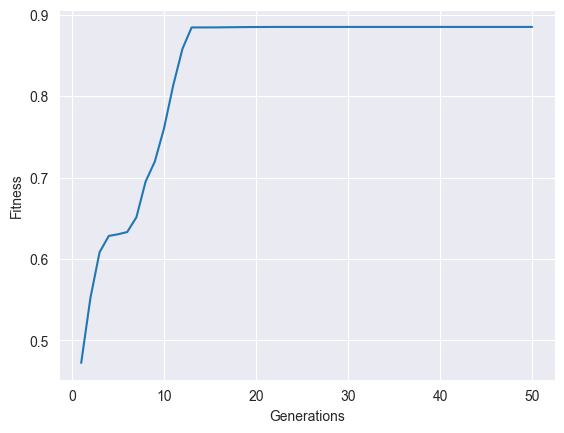

In [63]:
import matplotlib.pyplot as plt
plt.plot([x['gen'] for x in logbook[1:]], [x['avg'] for x in logbook[1:]])
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.show()